# KumoRFM SALT Evaluation

This notebook provides a step-by-step guide on how to evaluate the performance of `KumoRFM` on the [SALT](https://github.com/SAP-samples/salt) dataset.

SALT is designed to reflect real-world customer interactions within an Enterprise Resource Planning (ERP) system, where several fields are commonly missing from sales orders and must be predicted.
It comprises four (anonymized) core tables—sales documents, sales document items, customers, and addresses—amounting to approximately 5 million records in total.
The dataset defines eight missing fields as target variables for multi-class classification tasks.
These tasks are characterized by significant class imbalances, a wide range of class counts (up to 589), and challenges such as label diversity, noise, and distributional drift.

Let's start by installing the necessary packages:

In [ ]:
!pip install kumoai --pre --upgrade
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.2/282.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.3 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.11.7
    Uninstalling pydantic-2.11.7:
      Successfully uninstalled pydantic-2.11.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.27.0 requires pydantic<3.0.0,>=2.0.0, but you have pydantic 1.10.22 which is incompatible.
langchain-core 0.3.72 requires pydantic>=2.7.4, but you have pydantic 1.10.22 which is incompatible.
langchain 0.3.27 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 1.10.22 which is incompatible.
thinc 8.3.6 requires pydantic<3.0.0

In [ ]:
from kumoai.experimental import rfm

Ensure that we are authorized:

In [ ]:
import os

if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

In [ ]:
rfm.init()

Client has already been created. To re-initialize Kumo, please start a new interpreter. No changes will be made to the current session.


## Data Loading and Data Cleaning

The SALT dataset is available via the [Hugging Face dataset platform](https://huggingface.co/datasets/sap-ai-research/SALT).
You will need a Hugging Face API key to access it, which can be obtained as described [here](https://huggingface.co/docs/hub/en/security-tokens).

In [ ]:
import huggingface_hub

HUGGINGFACE_TOKEN="..."  # TODO Fill
huggingface_hub.login(HUGGINGFACE_TOKEN)

HTTPError: Invalid user token.

We are now ready to load the dataset into memory. The SALT dataset is divided into an artificial training and test dataset, in which customers and addresses are shared among the two sets, while salesdocuments and salesdocument items hold distinct information (splitted by time). In order to fit this dataset into `KumoRFM`, we need to reconstruct it into its original raw dataset. We do this by simply concatenating train and test records into a single table:

In [ ]:
import pandas as pd
from datasets import load_dataset

name = 'sap-ai-research/SALT'

sales = pd.concat([
    load_dataset(name, 'salesdocuments', split='train').to_pandas(),
    load_dataset(name, 'salesdocuments', split='test').to_pandas(),
], axis=0, ignore_index=True)
items = pd.concat([
    load_dataset(name, 'salesdocument_items', split='train').to_pandas(),
    load_dataset(name, 'salesdocument_items', split='test').to_pandas(),
], axis=0, ignore_index=True)
customers = load_dataset(name, 'customers', split='train').to_pandas()
addresses = load_dataset(name, 'addresses', split='train').to_pandas()

Let's look at a subset of the data:

In [ ]:
display(sales.head())

,SALESDOCUMENT,SALESOFFICE,SALESGROUP,CUSTOMERPAYMENTTERMS,SHIPPINGCONDITION,SALESDOCUMENTTYPE,SALESORGANIZATION,DISTRIBUTIONCHANNEL,ORGANIZATIONDIVISION,BILLINGCOMPANYCODE,TRANSACTIONCURRENCY,INCOTERMSCLASSIFICATION,CREATIONDATE,CREATIONTIME,__index_level_0__
0,0001984611,0010,AG,EI08,01,TA,0010,10,10,D011,EUR,DDP,2018-01-02,11:02:49,0
1,0001984614,0010,436,26,01,TA,0010,10,10,D011,EUR,CIP,2018-01-03,09:10:14,1
2,0001984696,0010,303,32,01,TA,0300,10,10,NL30,USD,DDP,2018-01-02,09:22:47,2
3,0001984697,0010,301,33,13,TA,0300,10,10,NL30,EUR,DDP,2018-01-02,09:58:41,3
4,0001984698,0010,341,32,13,ZIA,4200,10,10,DK20,DKK,DDP,2018-01-02,10:27:56,4


In [ ]:
display(items.head())

,SALESDOCUMENT,SALESDOCUMENTITEM,PLANT,SHIPPINGPOINT,SALESDOCUMENTITEMCATEGORY,PRODUCT,SOLDTOPARTY,SHIPTOPARTY,BILLTOPARTY,PAYERPARTY,INCOTERMSCLASSIFICATION,__index_level_0__
0,0001984611,000010,0001,0001,TAN,0103632587,6393610865,6393610865,6393610865,6393610865,DDP,393
1,0001984614,000010,0001,0001,TAN,5663960850,2781552396,1953914038,2781552396,2781552396,CIP,394
2,0001984696,000010,0310,0300,TAN,1461114184,8197936759,6484161189,8197936759,8197936759,DDP,406
3,0001984696,000020,0310,0300,ZTCH,1461114184,8197936759,6484161189,8197936759,8197936759,DDP,407
4,0001984697,000010,0310,0300,TAN,0163158092,8383348969,8383348969,8383348969,8383348969,DDP,408


We need to make a few adjustments and sanitize the data:

1. We merge the `CREATIONTIME` and `CREATIONDATE` column into a single `CREATIONDATETIME` column:

In [ ]:
date = sales['CREATIONDATE'].astype(str)
time = sales['CREATIONTIME'].astype(str)
sales['CREATIONDATETIME'] = pd.to_datetime(date + ' ' + time)
del sales['CREATIONDATE']
del sales['CREATIONTIME']

2. We add this `CREATIONDATETIME` column to the salesdocument items table as well. This is necessary to ensure the tasks of SALT on the salesdocument items table are assigned a unique timestamp to avoid temporal data leakage:

In [ ]:
items = pd.merge(
    left=items,
    right=sales[['SALESDOCUMENT', 'CREATIONDATETIME']],
    how='left',
    left_on='SALESDOCUMENT',
    right_on='SALESDOCUMENT',
)

3. We remove auto-generated columns:

In [ ]:
# Remove auto-generated columns:
del sales['__index_level_0__']
del items['__index_level_0__']
del customers['__index_level_0__']
del addresses['__index_level_0__']

4. We add a primary key to the salesdocument items table in order to ensure that we can reference its training and test records:

In [ ]:
items['ID'] = range(len(items))

5. There exists an `INCOTERMSCLASSIFICATION` column in both the salesdocuments and salesdocument items table, which are both used as a target downstream. Let's rename these columns to make the two tasks easily distinguishable:

In [ ]:
sales = sales.rename(
    columns={'INCOTERMSCLASSIFICATION': 'HEADERINCOTERMSCLASSIFICATION'})
items = items.rename(
    columns={'INCOTERMSCLASSIFICATION': 'ITEMINCOTERMSCLASSIFICATION'})

According to the SALT evaluation protocol, none of the eight target columns should be used as input feature. As such, for a given task, we make sure to exclude all remaining ones.

Note that you can simply change to a different task here by adjusting the `task` variable:

In [ ]:
sale_tasks = [
    'SALESOFFICE',
    'SALESGROUP',
    'CUSTOMERPAYMENTTERMS',
    'SHIPPINGCONDITION',
    'HEADERINCOTERMSCLASSIFICATION',
]
item_tasks = [
    'PLANT',
    'SHIPPINGPOINT',
    'ITEMINCOTERMSCLASSIFICATION',
]

task = 'ITEMINCOTERMSCLASSIFICATION'

sales = sales.drop([t for t in sale_tasks if t != task], axis=1)
items = items.drop([t for t in item_tasks if t != task], axis=1)

Finally, for the given task, we mask out all its test labels to prevent data leakage:

In [ ]:
if task in sale_tasks:
    num_test = load_dataset(name, 'salesdocuments', split='test').num_rows
    y_test = sales[task].iloc[-num_test:].to_numpy().copy()
    pkey_test = sales['SALESDOCUMENT'].iloc[-num_test:].to_numpy()
    task_pos = sales.columns.get_loc(task)
    sales.iloc[-num_test:, task_pos] = None
elif task in item_tasks:
    num_test = load_dataset(name, 'salesdocument_items', split='test').num_rows
    y_test = items[task].iloc[-num_test:].to_numpy().copy()
    pkey_test = items['ID'].iloc[-num_test:].to_numpy()
    task_pos = items.columns.get_loc(task)
    items.iloc[-num_test:, task_pos] = None
else:
    raise ValueError(f"Unsupported task '{task}'")

## Graph Creation

We are now ready to convert the SALT dataset into a Kumo `LocalGraph`:

In [ ]:
df_dict = {
    'sales': sales,
    'items': items,
    'customers': customers,
    'addresses': addresses,
}
graph = rfm.LocalGraph.from_data(df_dict, infer_metadata=False)

# "PRODUCT" is inferred as "text" column but should be marked as "categorical":
graph['items']['PRODUCT'].stype = 'categorical'

# Assign primary keys and time columns:
graph['sales'].primary_key = 'SALESDOCUMENT'
graph['sales'].time_column = 'CREATIONDATETIME'
graph['items'].primary_key = 'ID'
graph['items'].time_column = 'CREATIONDATETIME'
graph['customers'].primary_key = 'CUSTOMER'
graph['addresses'].primary_key = 'ADDRESSID'

# Assign edges:
graph.link(src_table='items', fkey='SALESDOCUMENT', dst_table='sales')
graph.link(src_table='items', fkey='SOLDTOPARTY', dst_table='customers')
graph.link(src_table='items', fkey='SHIPTOPARTY', dst_table='customers')
graph.link(src_table='items', fkey='PAYERPARTY', dst_table='customers')
graph.link(src_table='items', fkey='BILLTOPARTY', dst_table='customers')
graph.link(src_table='customers', fkey='ADDRESSID', dst_table='addresses');

Let's ensure that everything is set up correctly:

In [ ]:
graph.print_metadata()
graph.print_links()

### 🗂️ Graph Metadata

name,primary_key,time_column
sales,SALESDOCUMENT,CREATIONDATETIME
items,ID,CREATIONDATETIME
customers,CUSTOMER,-
addresses,ADDRESSID,-


### 🕸️ Graph Links (FK ↔️ PK)

- `customers.ADDRESSID` ↔️ `addresses.ADDRESSID`
- `items.BILLTOPARTY` ↔️ `customers.CUSTOMER`
- `items.PAYERPARTY` ↔️ `customers.CUSTOMER`
- `items.SHIPTOPARTY` ↔️ `customers.CUSTOMER`
- `items.SOLDTOPARTY` ↔️ `customers.CUSTOMER`
- `items.SALESDOCUMENT` ↔️ `sales.SALESDOCUMENT`

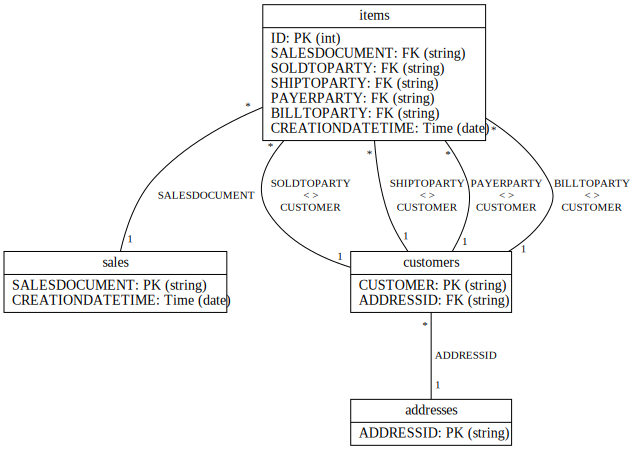

In [ ]:
graph.visualize(show_columns=False);

## Model Execution

Once the `LocalGraph` is set up, we are ready making predictions and evaluate `KumoRFM` performance.

Let's load the model:

In [ ]:
model = rfm.KumoRFM(graph)

Output()

The SALT tasks are multi-class classification tasks, in which we are asked to impute missing values. In `KumoRFM`, we can simply model this via the **Predictive Query Language** by predicting the target column on each of the tables:

In [ ]:
if task in sale_tasks:
    query = f"PREDICT sales.{task} FOR sales.SALESDOCUMENT IN ({{indices}})"
else:
    query = f"PREDICT items.{task} FOR items.ID IN ({{indices}})"

We are now ready to iterate over all test entities (with a batch size up to `1000`) and obtain their predictions. In order to speed things up, we only run over a subset of test entities (defined by `max_test_steps`). For multi-class classification tasks, `KumoRFM` will return the probabilities of the top-10 most likely classes for each entity.

In [ ]:
import tqdm
import numpy as np

batch_size = 1000
max_test_steps = 10

ys_pred = []
steps = list(range(0, len(pkey_test), batch_size))[:max_test_steps]
for i, step in enumerate(tqdm.tqdm(steps)):
    indices = pkey_test[step:step + batch_size].tolist()

    if task in sale_tasks:
        _query = query.format(indices=', '.join(f"'{i}'" for i in indices))
    else:
       _query = query.format(indices=', '.join(str(i) for i in indices))

    df = model.predict(
        _query,
        run_mode='best',  # Trades runtime in favor of better model performance.
        anchor_time='entity',  # Use entity table time as anchor time.
        num_hops=3,  # Ensure that we reach every table.
        verbose=i == 0,  # Prevent excessive logging.
    )

    # Save the predicted top-10 classes sorted by probability:
    ys_pred.append(df['CLASS'].to_numpy().reshape(len(indices), -1))

y_pred = np.concatenate(ys_pred, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

Output()

100%|██████████| 10/10 [02:44<00:00, 16.43s/it]


Finally, we are ready to evaluate our predictions by comparing them to the ground-truth test labels. The metric of choice here is Mean Reciprocal Rank (MRR), *i.e.* the reciprocal rank of the correct prediction averaged over all test labels.

Let's implement it quickly:

In [ ]:
match = y_test[:len(y_pred)].reshape(-1, 1) == y_pred
rank = match.astype(float).argmax(axis=-1) + 1
reciprocal_rank = 1.0 / rank
reciprocal_rank[match.sum(axis=-1) == 0.0] = 0.0

print(f'MRR: {reciprocal_rank.mean():.4f}')

MRR: 0.8554


And that's it! If you run the model over all different tasks, you will observe that `KumoRFM` is on par to the best baseline reported in the [SALT](https://arxiv.org/html/2501.03413v1) paper, although we never trained anything.
Noteworthy, we are even underestimating the true MRR here, since for any correct prediction that is not within the top-10 most likely classes, we assign it a reciprocal rank of `0`.
The only dataset where `KumoRFM` underperforms a bit is the `SALESGROUP` task, which is explained by the fact that it is the task with the most classes (589).

We can further improve the performance by fine-tuning `KumoRFM` on SALT, but this is a story for another notebook. Happy hacking!